# Plotting Time Series from Multiple Ensemble Members
## (using Regions Defined by Shape Files!)
### Authors

Samantha Stevenson sstevenson@ucsb.edu

### Table of Contents

[Goals](#purpose)

[Import Packages](#path)

[Load and Query the CMIP6 AWS Catalog](#load)

[Read in Data as an Xarray Object](#xarray)

[Define a Region Using Shapefiles](#shapefiles)

[Plot Time Series](#time_series)

<a id='purpose'></a> 
## **Goals**

In this tutorial, we will be reading in the database of Coupled Model Intercomparison Project phase 6 (CMIP6) output hosted by Amazon Web Services and exploring its contents. 

The steps in this tutorial build on the skills we learned in previous tutorials:
- [Read in Data and Plot a Time Series](https://github.com/climate-datalab/Time-Series-Plots/blob/main/1.%20Read%20in%20Climate%20Data%20%2B%20Plot%20a%20Regionally%20Averaged%20Time%20Series.ipynb)
  (regional averaging, time series plotting)
- [Opening and Querying the CMIP6 AWS Database](https://github.com/climate-datalab/CMIP6_AWS/blob/main/1.%20Opening%20and%20Querying%20the%20CMIP6%20Catalog.ipynb)  (data access via Amazon Web Services)
- [Mapping Climate Data](https://github.com/climate-datalab/Map-Plots/blob/main/1.%20Mapping%20Climate%20Data.ipynb) (putting spatial data onto a map using Cartopy)

The first few sections of this tutorial contain the same coding steps as [tutorial 1 in this repo](https://github.com/climate-datalab/EnsembleAnalysis/blob/main/1.%20Plotting%20Multiple%20Ensemble%20Members.ipynb), but then we build on this to illustrate how one can use shape files to extract data from spatially irregular regions.

<a id='path'></a> 
## **Import Packages**

As always, we begin by importing the necessary packages for our analysis. This tutorial assumes you're starting with an environment in which `intake`, `intake-esm`, and `s3fs` are already installed - for details on those packages, see the [CMIP6 AWS repo](https://github.com/climate-datalab/CMIP6_AWS)!

We'll also need a new package for this tutorial: `geopandas`. [Geopandas](https://geopandas.org/en/stable/index.html) is designed to facilitate working with geospatial data in Python; it layers the functionality of Pandas with the shape-handing abilities of Shapely to allow users to perform operations on geometrics objects. 

Last but not least: we'll also import the coordinate reference system handling functionality from Cartopy (`cartopy.crs`; for more details see the [Cartopy CRS docs page](https://scitools.org.uk/cartopy/docs/latest/getting_started/crs.html)). This will allow us to reproject geospatial data onto a given CRS using Geopandas later on! 

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import intake
import s3fs
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Point

ERROR 1: PROJ: proj_create_from_database: Open of /opt/anaconda3/envs/eds296-stevenson/share/proj failed


<a id='load'></a> 
## **Load and Query the CMIP6 AWS Catalog**

As we did in previous tutorials, we'll load the CMIP6 database hosted by Amazon Web Services. More detail on that database is available on the [Amazon Registry of Open Data](https://registry.opendata.aws/cmip6/).


We first begin with opening the data catalog itself (_note - this step can be fairly slow on some machines_):

In [2]:
# Open the CMIP6 data catalog, store as a variable
catalog = intake.open_esm_datastore('https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json')

We'll use the same query that we constructed earlier: pulling all members of the historical ensemble run with CESM2. For more detail on this, see [tutorial 1](https://github.com/climate-datalab/EnsembleAnalysis/blob/main/1.%20Plotting%20Multiple%20Ensemble%20Members.ipynb)!

In [3]:
# Specify search terms to query catalog 
# activity_id: which project do you want? CMIP = historical data
activity_ids = ['CMIP'] 

# source_id: which model do you want? Let's say CESM2
source_id = ['CESM2']

# experiment_id: what experimental configuration do you want? Here we want historical and the four main SSPs
experiment_ids = ['historical']

# table_id: which part of the Earth system and time resolution do you want? Here we want monthly atmosphere data
table_id = 'Amon' 

# variable_id: which climate variable do you want? Here we want surface air temperature
variable_id = 'tas' 

In [4]:
# Search through catalog, store results in "res" variable
res = catalog.search(activity_id=activity_ids, source_id=source_id, experiment_id=experiment_ids, 
                     table_id=table_id, variable_id=variable_id)

# Display data frame associated with results
display(res.df)

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,NCAR,CESM2,historical,r4i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190308
1,CMIP,NCAR,CESM2,historical,r6i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190308
2,CMIP,NCAR,CESM2,historical,r3i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190308
3,CMIP,NCAR,CESM2,historical,r1i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190308
4,CMIP,NCAR,CESM2,historical,r2i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190308
5,CMIP,NCAR,CESM2,historical,r5i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190308
6,CMIP,NCAR,CESM2,historical,r9i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190311
7,CMIP,NCAR,CESM2,historical,r8i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190311
8,CMIP,NCAR,CESM2,historical,r7i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190311
9,CMIP,NCAR,CESM2,historical,r10i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190313


In [5]:
# Define an empty list
ens_data = []

# Retrieve number of entries in the data frame
num = res.df.shape[0]

# Loop over all entries in the data frame
for mem in range(num):
    print(res.df.member_id[mem])
    # Store data from each entry as xarray, add to list
    temp_data = xr.open_zarr(res.df['zstore'][mem], storage_options={'anon': True})
    ens_data.append(temp_data)

# Concatenate the list into a single xarray object
ens_data = xr.concat(ens_data, dim="member")

# Store the actual member information as values of the new dimension
ens_data = ens_data.assign_coords(member=("member", res.df.member_id))

# Convert units from K to C
ens_data['tas'] = ens_data['tas'] - 273.15

r4i1p1f1
r6i1p1f1
r3i1p1f1
r1i1p1f1
r2i1p1f1
r5i1p1f1
r9i1p1f1
r8i1p1f1
r7i1p1f1
r10i1p1f1
r11i1p1f1


<a id='shapefiles'></a> 
## **Define a Region Using Shapefiles**

Now that the data have been read in, we can use it to plot a time series. In previous tutorials, we had been specifying lat/lon ranges using a rectangular box: but we can do better now! A common desire in analyzing geospatial data is to select regions with irregular boundaries - this is often done using shapefiles which specify the lat/lon coordinates of the boundary around a given region. 

There are many sources of shapefiles around the Internet: here we'll work with the [California Geographic Boundaries](https://catalog.data.gov/dataset/ca-geographic-boundaries) datasets. These contain information for state, county, and local place boundaries - to make sure we have a large enough region, let's use the state boundary. 

The shape file for the California state boundary was downloaded from the link above and is stored in this repo (see folder "ca_state"). It can be read in using the Geopandas `.read_file()` method!

While we're at it, let's also reproject the file to use a specific coordinate reference system - in this case, the Plate Carree projection. This isn't strictly required since the shape file does contain a default CRS, but we _will_ need to make sure in a minute that our CRS is consistent between the shape file and the climate model data, so we might as well explicitly include a reprojection step just to make sure we don't forget to check!

In [6]:
# Read in shapefile for CA counties
gdf = gpd.read_file('ca_state/CA_State.shp')

# Reproject the shapefile to use the PlateCarree projection
gdf = gdf.to_crs(epsg=4326)

Now that we have our shape file, the next task is to take the lat and lon coordinates from the climate model grid, and figure out which of those points lie within the boundaries of the shape (in this case, the California state borders). This requires a couple of steps:

- Converting the 

In [7]:
# Make 2D lat, lon
lon_vals = ens_data.lon.values
lon_vals = np.where(lon_vals > 180, lon_vals - 360, lon_vals)

lon2d, lat2d = np.meshgrid(lon_vals, ens_data.lat.values)

# Create a GeoDataFrame from the xarray dataset's coordinates
points = [Point(lon, lat) for lon, lat in zip(lon2d.flatten(), lat2d.flatten())]
points_gdf = gpd.GeoDataFrame(geometry=points, crs="EPSG:4326")

# Print the points to see what they look like
#print(points_gdf)

# Spatial join to find points within the shapefile
joined = gpd.sjoin(points_gdf, gdf, how="inner", predicate="intersects")

# Create a mask based on the spatial join
mask = np.isin(np.arange(points_gdf.shape[0]), joined.index)
mask_2d = mask.reshape(lat2d.shape)

# Apply mask
masked_data = ens_data.where(mask_2d)


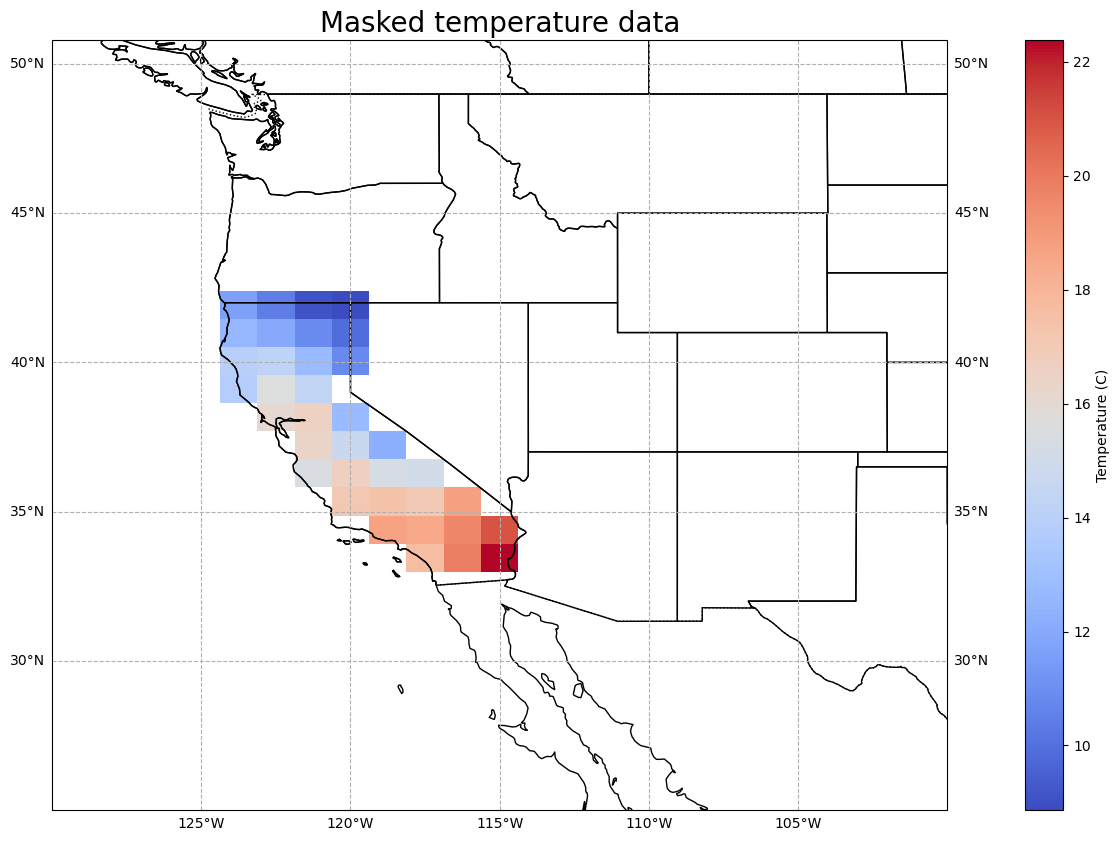

In [8]:
# Define object containing PlateCarree projection
map = ccrs.PlateCarree()

# Create figure/axis objects, use the map object to specify associated projection
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": map})

# Plot temperature data on the axes using the coolwarm colormap
plot = ax.pcolormesh(masked_data.lon, masked_data.lat, masked_data.isel(member=0).mean(dim="time").tas, transform=map, cmap="coolwarm")
# Set lat/lon extent
ax.set_extent([-130, -100, 25, 50])
# Add colorbar and label it
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Temperature (C)")
# Add coastline/border lines
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.add_feature(cfeature.STATES)
# Add grid lines
gl = ax.gridlines(draw_labels=True, linestyle="--") 
gl.top_labels = False
# Add title, show plot
ax.set_title("Masked temperature data", fontsize= 20)
plt.show()

In order to work with this shape file in combination with our climate model information, we need to define a _coordinate reference system (CRS)_ for both. This is essentially a framework for locating different spatial points on the surface of Earth; more information on coordinate reference systems can be found [here](https://www.earthdatascience.org/courses/earth-analytics/spatial-data-r/intro-to-coordinate-reference-systems/)

The code block below defines our CRS using the [Plate Carree](https://pro.arcgis.com/en/pro-app/latest/help/mapping/properties/plate-carree.htm) projection, centered at a longitude of 180, and reprojects the data in the CA shape file to use the same projection. 

_Note: the `epsg=4326` syntax below is how you refer to the Plate Carree projection in the language of Geopandas! The [EPSG database](https://epsg.org/home.html) has numbered various projections/CRS, and 4326 is the one that corresponds to Plate Carree._

In [9]:
# Reproject the shapefile to use the PlateCarree projection
gdf = gdf.to_crs(epsg=4326)

# Make 2D lat, lon
lon2d, lat2d = np.meshgrid(ens_data.lon.values, ens_data.lat.values)

# Create a GeoDataFrame from the xarray dataset's coordinates
points = [Point(lon, lat) for lon, lat in zip(lon2d.flatten(), lat2d.flatten())]
points_gdf = gpd.GeoDataFrame(geometry=points, crs="EPSG:4326")

# Print the points to see what they look like
print(points_gdf)

# Spatial join to find points within the shapefile
joined = gpd.sjoin(points_gdf, gdf, how="inner", predicate="intersects")

# Create a mask based on the spatial join
mask = np.isin(np.arange(points_gdf.shape[0]), joined.index)
mask_2d = mask.reshape(lat2d.shape)

#masked_data = temp_data.where(mask_2d)


                         geometry
0       POINT (0.00000 -90.00000)
1       POINT (1.25000 -90.00000)
2       POINT (2.50000 -90.00000)
3       POINT (3.75000 -90.00000)
4       POINT (5.00000 -90.00000)
...                           ...
55291  POINT (353.75000 90.00000)
55292  POINT (355.00000 90.00000)
55293  POINT (356.25000 90.00000)
55294  POINT (357.50000 90.00000)
55295  POINT (358.75000 90.00000)

[55296 rows x 1 columns]


In [10]:
# Define function to generate area weights
def weights(dat):
    # Calculate weighting factor = cosine of latitude
    coslat = np.cos(np.deg2rad(dat.lat))
    weight_factor = coslat / coslat.mean(dim='lat')
    
    # Weight all points by the weighting factor
    computed_weight = dat * weight_factor
    
    # Return the set of weights: this has dimension equal to that of the input data
    return computed_weight

In [11]:
# Weight the data by grid box area
dat_weighted = weights(masked_data)

# Average over lat, lon
dat_wgtmn = dat_weighted.mean(dim=['lat', 'lon'])

# Calculate annual mean
dat_wgtmn = dat_wgtmn.groupby('time.year').mean()

In [12]:
# Extract the values of the weighted temperature array to speed things up
tas = dat_wgtmn.tas.values

# Store the number of ensemble members
nmems = tas.shape[1]

# Also extract the ensemble member names
memnames = dat_wgtmn.member.values

In [13]:
# Calculate ensemble mean
ens_mean = dat_wgtmn.mean(dim="member").tas.values

# Ensemble standard deviation
ens_std = dat_wgtmn.std(dim="member").tas.values

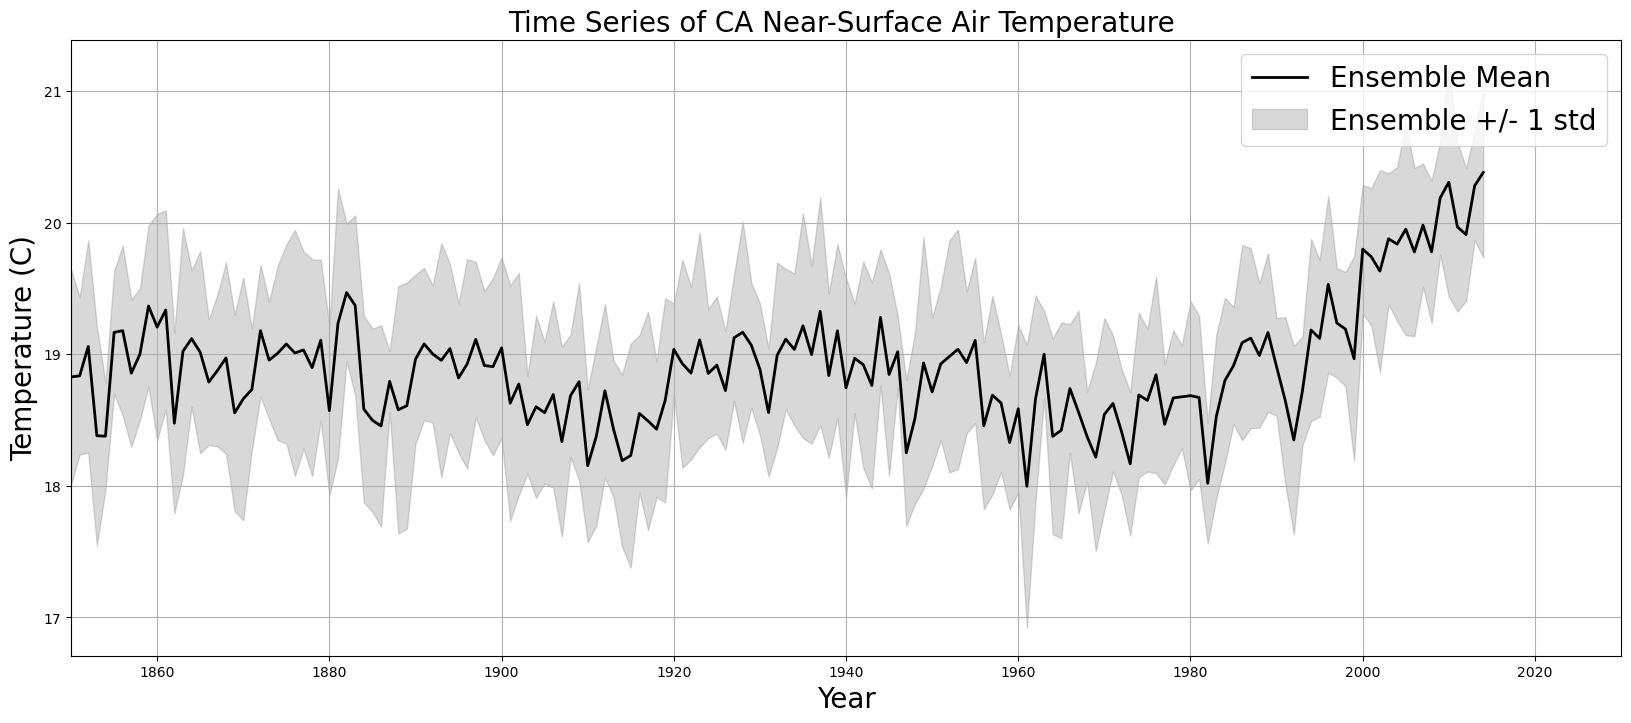

In [14]:
# 1) Ensemble standard deviation

# Set up a blank figure for plotting
fig, ax = plt.subplots(figsize=(20, 8))

# Loop over all ensemble members, plot the time series for each one
ax.plot(dat_wgtmn.year, ens_mean, color='k', linewidth=2, label="Ensemble Mean")
ax.fill_between(dat_wgtmn.year, ens_mean - ens_std, ens_mean + ens_std, color='gray', alpha=0.3, label="Ensemble +/- 1 std")

# Set plotting parameters
ax.set_title("Time Series of CA Near-Surface Air Temperature ", fontsize=20)
ax.set_xlabel("Year", fontsize=20)
ax.set_ylabel("Temperature (C)", fontsize=20)
ax.set_xlim([1850, 2030])
ax.legend(fontsize=20)
ax.grid()
plt.show()